In [8]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})
plt.rcParams['figure.figsize'] = (30, 15)

This journal documents the manipulation of PV installation data for Global installs. This covers selection of data, and weighting by marketshare.

In [9]:
cwd = os.getcwd() #grabs current working directory
df_installs_raw = pd.read_csv(cwd+"/../../PV_ICE/baselines/SupportingMaterial/PVInstalls_World_AllSources.csv", index_col='Year')
sources = df_installs_raw.columns
print(len(sources))

4


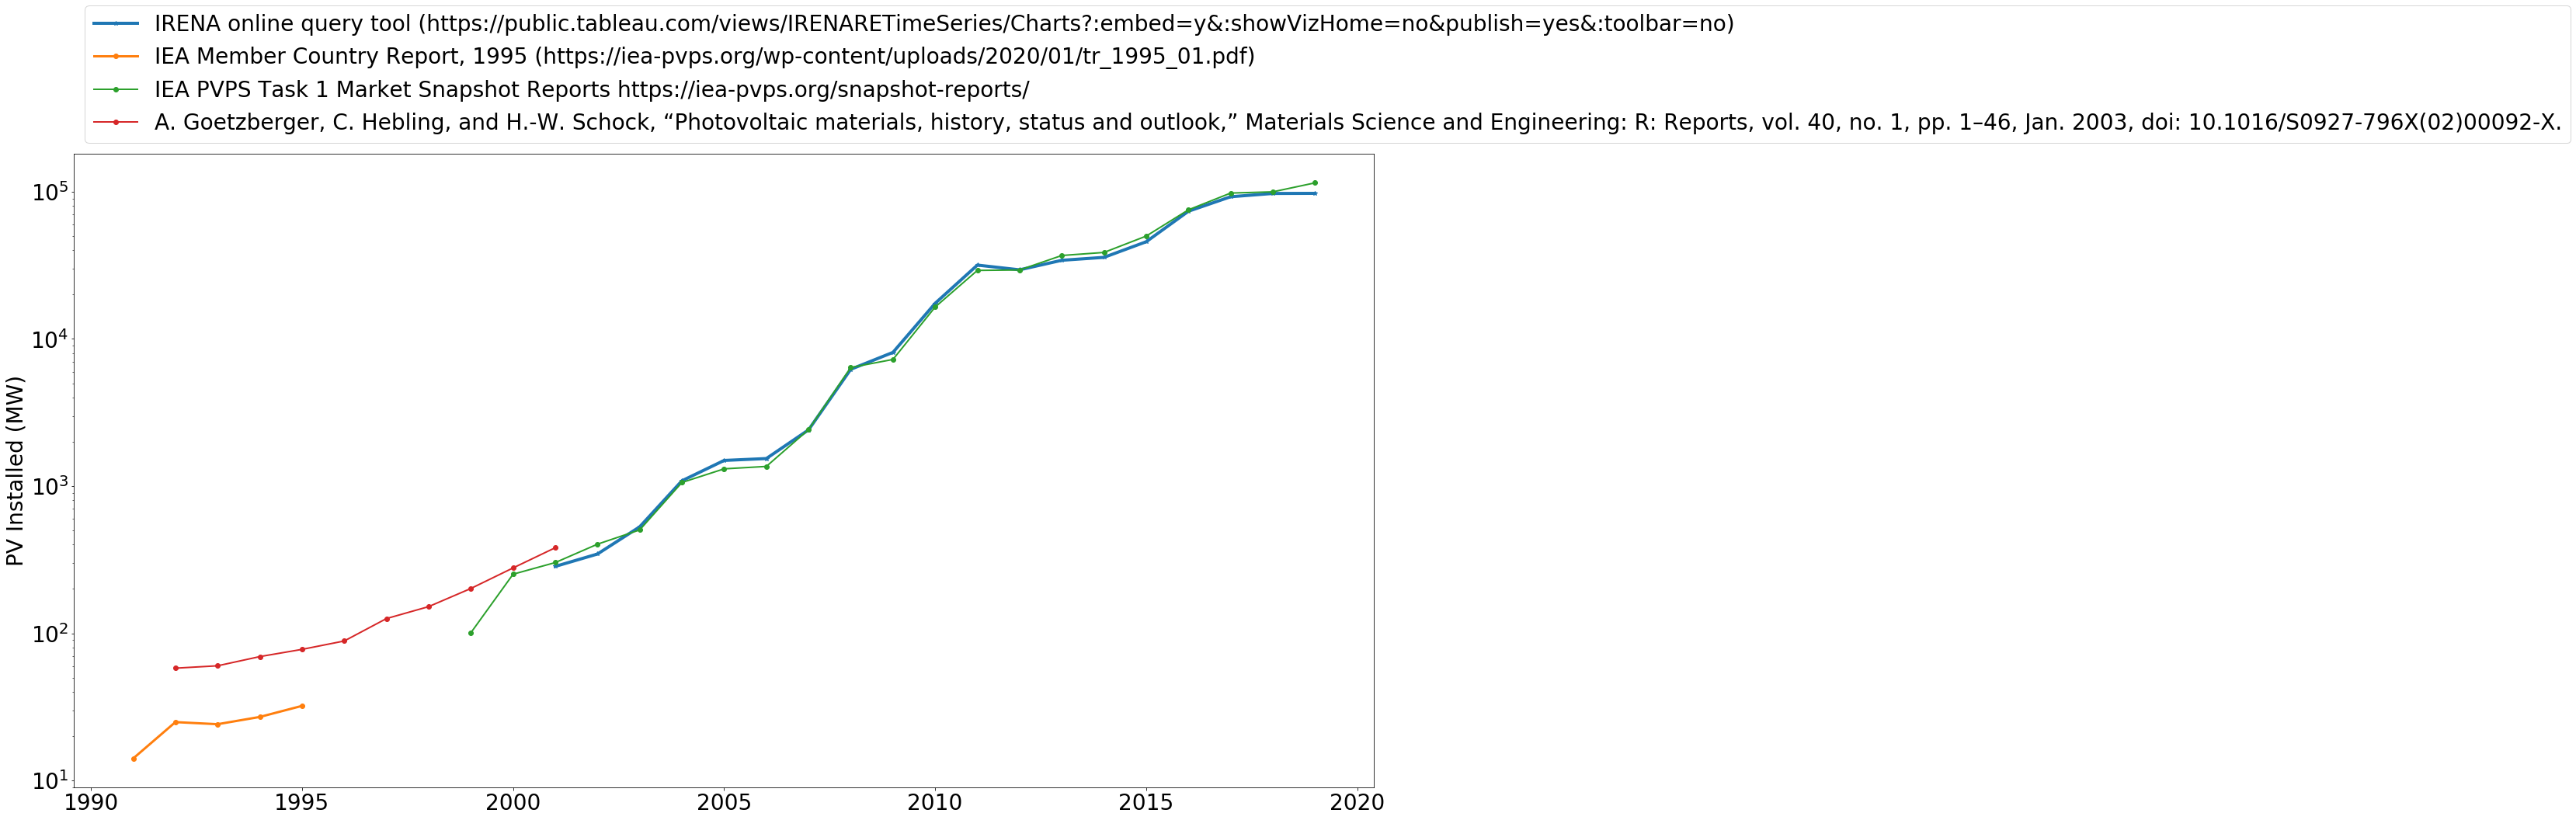

In [10]:
plt.plot(df_installs_raw.index,df_installs_raw[sources[0]],lw=4,marker='*',label=sources[0])
plt.plot(df_installs_raw.index,df_installs_raw[sources[1]],lw=3,marker='o',label=sources[1])
plt.plot(df_installs_raw.index,df_installs_raw[sources[2]],lw=2,marker='o',label=sources[2])
plt.plot(df_installs_raw.index,df_installs_raw[sources[3]],lw=2,marker='o',label=sources[3])

plt.yscale('log')
plt.ylabel('PV Installed (MW)')
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
#plt.plot(df_installs_raw, marker='o')

# Select the data to use for installs

Based on the above graph, we will utilize Goetzberger data through 2000, then IRENA online query tool after 2000.

In [35]:
#Before 2000 = Goetz
installs_old = df_installs_raw.loc[(df_installs_raw.index<=2000) & (df_installs_raw.index>=1995)]
installs_old_Goetz = pd.DataFrame(installs_old[sources[3]])
installs_old_Goetz.columns = ['installed_pv_MW']

#After 2000 = IRENA
installs_recent = df_installs_raw.loc[(df_installs_raw.index>2000) & (df_installs_raw.index<2020)]
installs_recent_IRENA = pd.DataFrame(installs_recent[sources[0]])
installs_recent_IRENA.columns = ['installed_pv_MW']
#print(installs_recent_IRENA)

### Collect the installation data together into a single df

Text(0.5, 1.0, 'Installations of PV Globally (MW) since 1995')

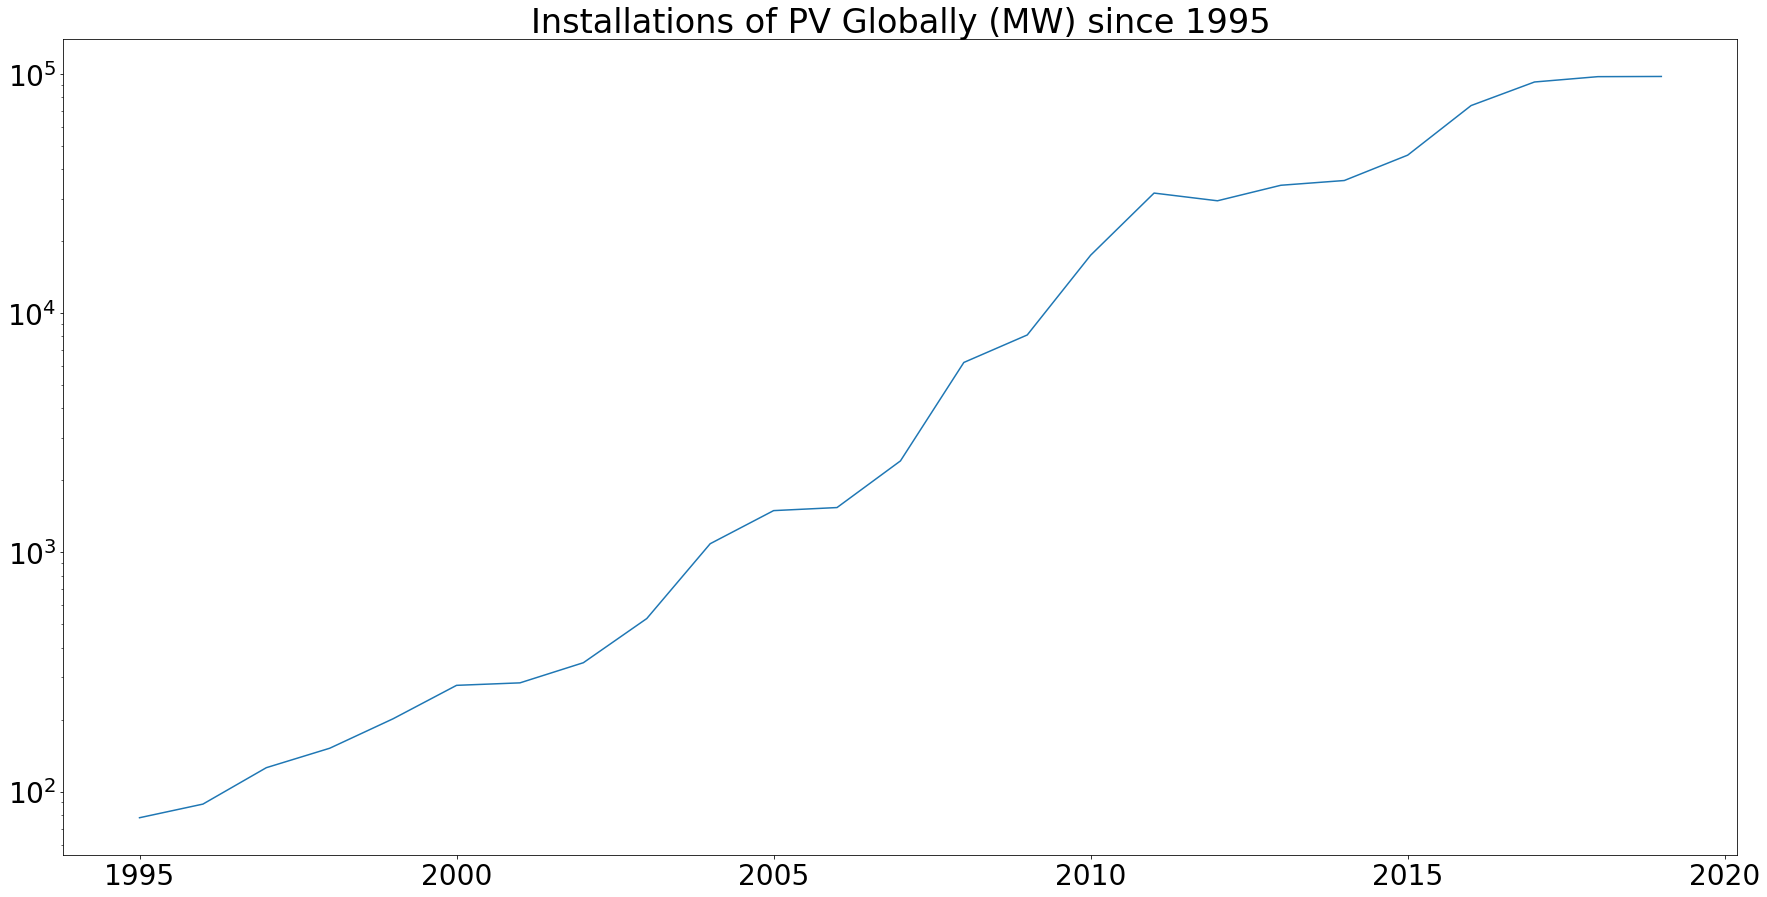

In [36]:
installs = pd.concat([installs_old_Goetz,installs_recent_IRENA])
plt.plot(installs)
plt.yscale('log')
plt.title('Installations of PV Globally (MW) since 1995')

# Marketshare weight the installation data for percent of Silicon vs Thin Film

In addition to compiling a single installation record for 1995 through the present, this data is total cumulative, but the tool it currently considering crystalline silicon technology only (i.e. mono and multi, but not ribbon or amorphous).

In [38]:
cwd = os.getcwd() #grabs current working directory
df_raw_mrktshr_siVtf = pd.read_csv(cwd+"/../../PV_ICE/baselines/SupportingMaterial/MarketShare_global_c-SiVSthinfilm.csv", index_col='Year')
refs = df_raw_mrktshr_siVtf.columns
print(len(refs))

4


(0, 100)

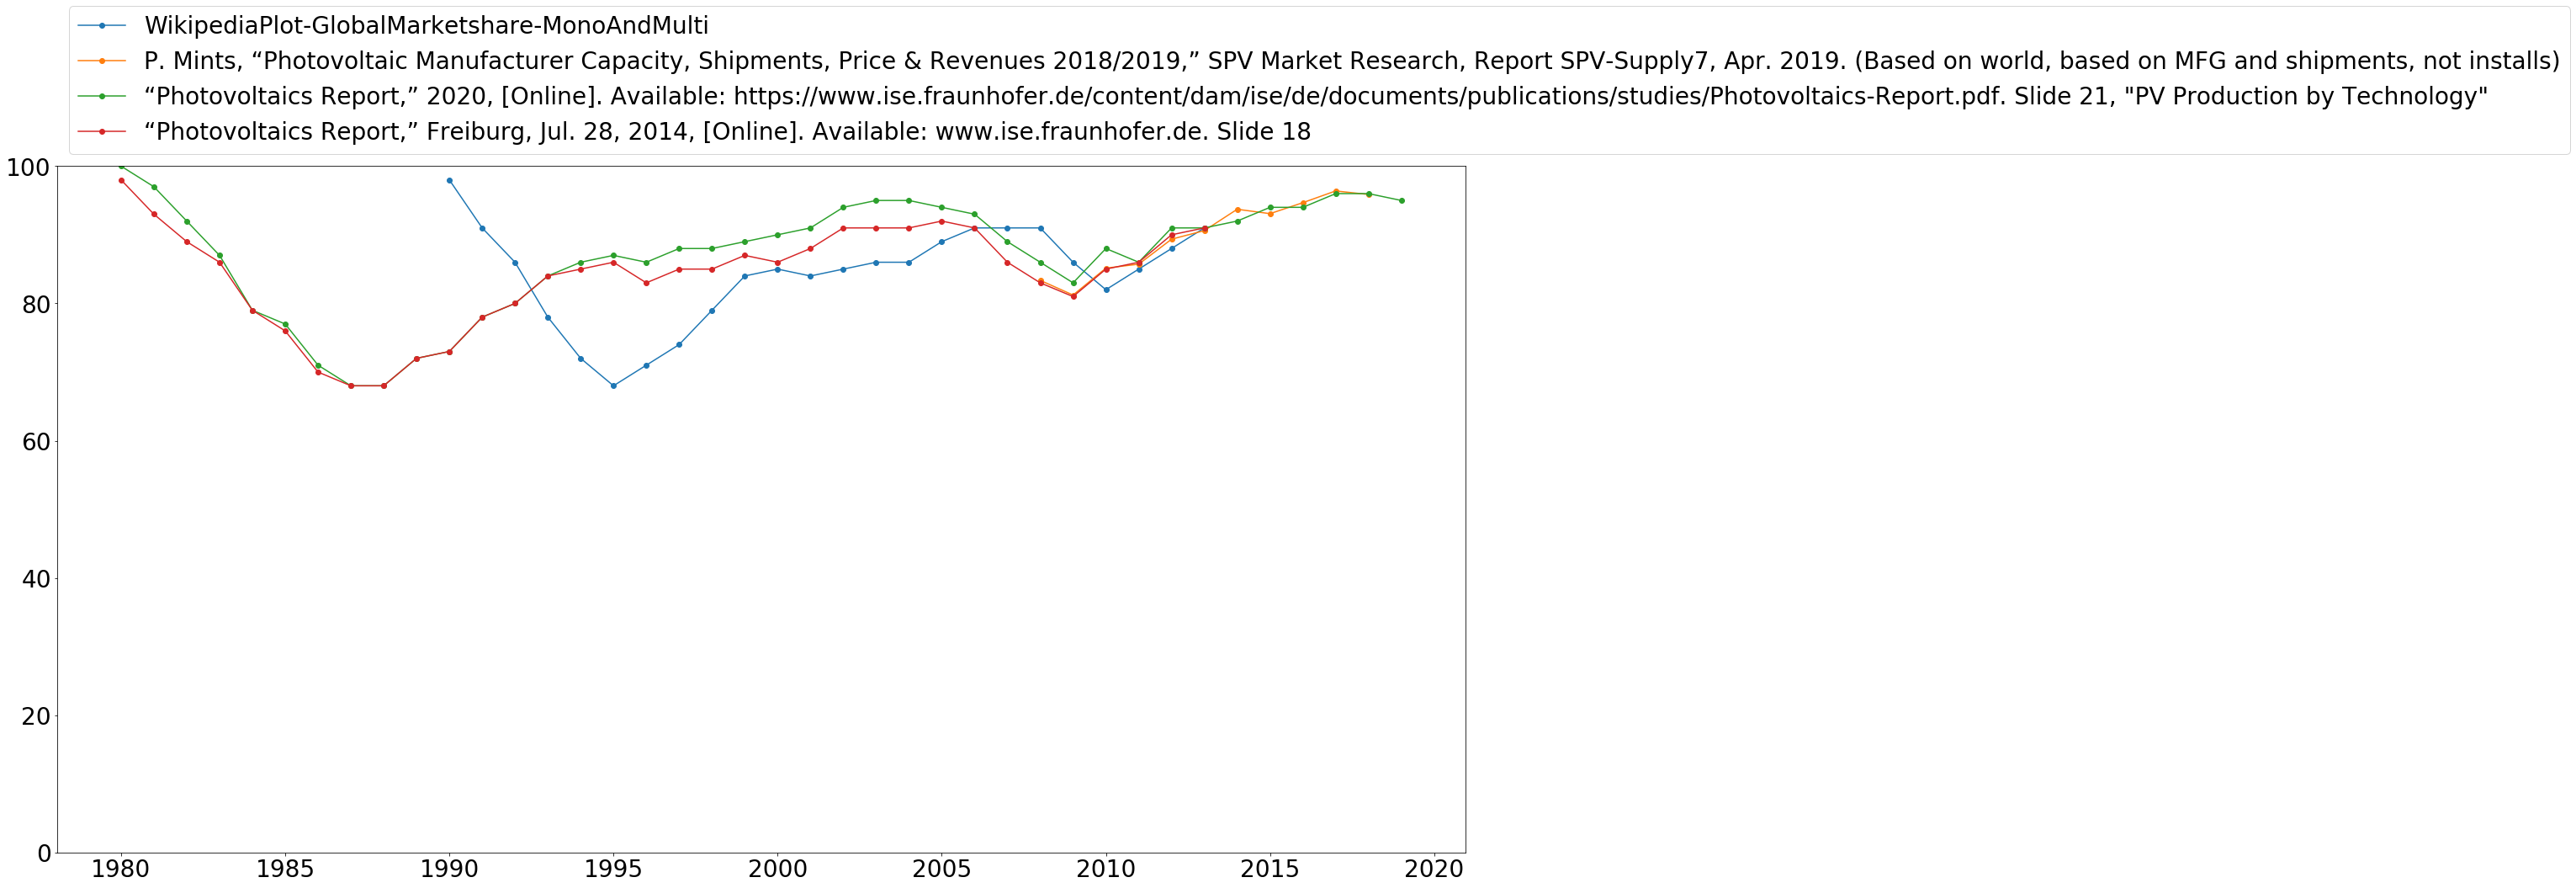

In [41]:
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[0]],marker='o',label=refs[0])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[1]],marker='o',label=refs[1])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[2]],marker='o',label=refs[2])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[3]],marker='o',label=refs[3])
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.ylim(0,100)

The 2020 Fraunhofer and 2014 Fraunhofer appear to agree reasonably closely, and Mints agrees closely for the amount of time there is overlap. The unknown sourced wikipedia figure doesn't agree until 2010, but given the unknown source, it will be discarded. We will use the Fraunhofer ISE 2020 market share data for the entire time period.

In [43]:
df_mrktshr_global =  pd.DataFrame(df_raw_mrktshr_siVtf[refs[2]])
mrktshr_global = df_mrktshr_global.loc[(df_mrktshr_global.index>=1995) & (df_mrktshr_global.index<2020)]
mrktshr_global.columns = ['Global_MarketShare']
#print(mrktshr_global)

      Global_MarketShare
Year                    
1995                87.0
1996                86.0
1997                88.0
1998                88.0
1999                89.0
2000                90.0
2001                91.0
2002                94.0
2003                95.0
2004                95.0
2005                94.0
2006                93.0
2007                89.0
2008                86.0
2009                83.0
2010                88.0
2011                86.0
2012                91.0
2013                91.0
2014                92.0
2015                94.0
2016                94.0
2017                96.0
2018                96.0
2019                95.0


(0, 1.1)

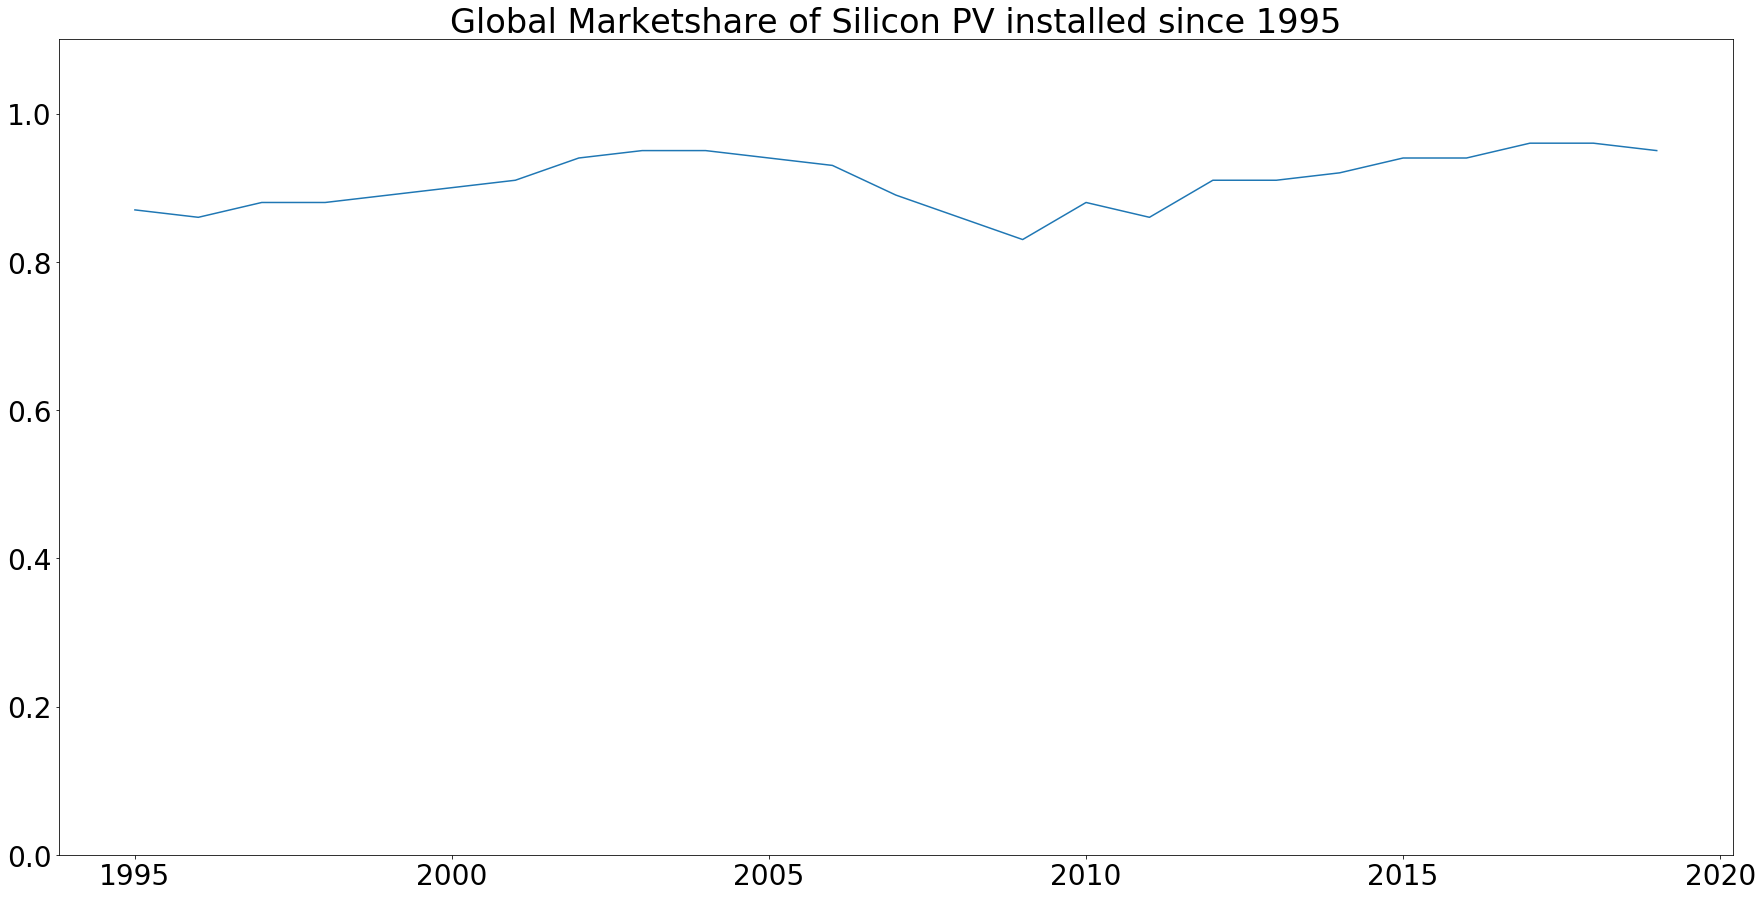

In [45]:
#convert to decimal
mrktshr_global_pct = mrktshr_global/100
plt.plot(mrktshr_global_pct)
plt.title('Global Marketshare of Silicon PV installed since 1995')
plt.ylim(0,1.1)

# Marketshare weight PV installs by percent Silicon
Now we have a marketshare percentage of silicon for 1995 through 2019. We will multiply the PV installs by this silicon marketshare to get the MW of silicon PV installed globally since 1995.

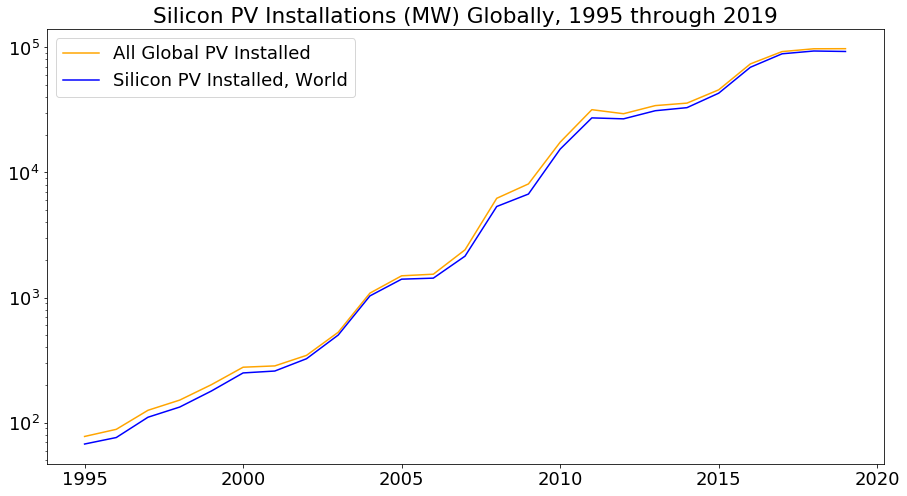

In [48]:
#put the two dataframes together, joining for available data (excludes NANs)
dfs = [installs,mrktshr_global_pct]
df = pd.concat(dfs, axis=1, join='inner')
df_clean = df.dropna()
#creates the marketshare weighted c-Si install data
world_si_installs = df_clean.agg('prod', axis='columns') 

#print(us_si_installs)
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (15, 8)
plt.plot(installs, label='All Global PV Installed', color='orange')
plt.plot(world_si_installs, label='Silicon PV Installed, World', color='blue')
plt.yscale('log')
plt.title('Silicon PV Installations (MW) Globally, 1995 through 2019')
plt.legend()

In [49]:
world_si_installs.to_csv(cwd+'/../../PV_ICE/baselines/SupportingMaterial/output_Global_SiPV_installs.csv', index=True)

This data only takes installs through 2019. For the remaining years through 2050, a compound annual growth rate of 8.9% was used to predict increasing installations. This compound annual growth rate was sourced from IRENA 2016 EoL Mangement Report and IRENA 2019 Future of PV Report.